# Loan Status Prediction

In [1]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pickle

- Load semua Library yang saya perlukan

## Understanding Data

In [2]:
df= pd.read_csv('Dataset_A_loan.csv')
print(df.shape)
df.head()

(45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948.0,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High School,12282.0,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High School,12438.0,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753.0,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135.0,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1


- Load datasetnya dan melihat 5 contoh sample data tersebut
- Saya juga menampilkan shape dari data itu untuk mengetahui jumlah baris dan kolom dari dataset tersebut 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

- Selain melihat jumlah baris dan kolom, saya juga check kesesuaian tipe data dan melihat apakah ada Null Values pada setiap kolom
- Berdasarkan hasil, tipe data sudah sesusai dan kolom person_income memiliki Null Values

In [4]:
df.loan_status.value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

- Perbandingan loan status menunjukkan ketidakseimbangan kelas

## Pre-processing

### Split Data

In [5]:
x= df[df.columns.drop(['loan_status'])]
y= df['loan_status']

- Memisahkan kolom yang akan di prediksi (y) dengan kolom fitur (x)

In [6]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state= 42)

- Data dibagi menjadi train dan test dengan proporsi 80:20. Pemisahan ini bertujuan agar model dapat berlatih dan diuji dengan data yang belom pernah dilihat

In [7]:
print("Distribution loan_status in train data")
print(pd.Series(y_train).value_counts())

print("\nDistribution loan_status in test data")
print(pd.Series(y_test).value_counts())

Distribution loan_status in train data
loan_status
0    28010
1     7990
Name: count, dtype: int64

Distribution loan_status in test data
loan_status
0    6990
1    2010
Name: count, dtype: int64


- Disini cuman mau lihat distribusi kolom yang mau diprediksi di data train dan test. Karena dari awal distribusinya tidak merata, maka disini juga sudah pasti tidak merata
- Bila nanti hasil modelnya jelek, nanti akan dilakukan sampling

### Null Value Handling

In [8]:
print('Null Values in x train')
print(x_train.isnull().sum())

Null Values in x train
person_age                           0
person_gender                        0
person_education                     0
person_income                     1769
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
dtype: int64


- Seperti yang sudah kita lihat di df.info() tadi, kolom person_income ada Null Values
- Data ini akan saya impute agar tidak mengurangi jumlah data yang dapat dilakukan untuk proses training serta mempertahankan informasi sebanyak mungkin

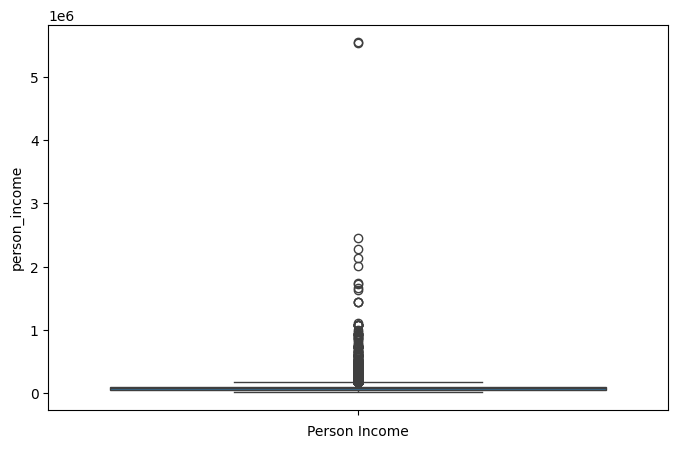

Median Person Income: 67104.0


In [9]:
plt.figure(figsize= (8,5))
sns.boxplot(y= x_train['person_income'])
plt.xlabel('Person Income')
plt.show()

print(f"Median Person Income: {x_train['person_income'].median()}")

- Karena data memiliki outliers yang cukup ekstrem, maka saya melakukan impute dengan median. Penggunaan median bertujuan agar hasil imputenya tidak terganggu dengan nilai ekstrem dan tetap merepresentasikan nilai tengah dengan benar

In [10]:
x_train['person_income'].fillna(x_train['person_income'].median(), inplace= True)

x_test['person_income'].fillna(x_test['person_income'].median(), inplace= True)

C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\1278838016.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['person_income'].fillna(x_train['person_income'].median(), inplace= True)
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\1278838016.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

- Melakukan imputasi dengan nilai median
- Preprocessing harus diterapkan pada data test juga agar konsisten dan memastikan model menerima data dengan struktur dan skala yang sama seperti data latih

In [11]:
print('Null Values in x train')
print(x_train.isnull().sum())

Null Values in x train
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
dtype: int64


- Null Values sudah di handle dengan benar

### Duplicate Data Handling

In [12]:
print(x_train.duplicated().sum())

0


- Tidak ada data duplikat sehingga tidak perlu di handle lebih lanjut

### Anomaly Handling

In [14]:
category= []
numerical= []

for i in x_train.columns:
  if 'int'in str(x_train[i].dtype) or 'float' in str(x_train[i].dtype):
    numerical.append(i)
  else:
    category.append(i)

print(f"Kolom Categorial: {category}")
print(f"Kolom Numerical: {numerical}")

Kolom Categorial: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Kolom Numerical: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


- Kolom dipisahkan menjadi kolom kategori dan numerik untuk memudahkan analisis distribusi dan kesalahan pada setiap kolom

In [15]:
for i in category:
  print(x_train[i].value_counts(), '\n')

person_gender
male       19782
female     16149
Male          35
fe male       34
Name: count, dtype: int64 

person_education
Bachelor       10772
Associate       9607
High School     9508
Master          5609
Doctorate        504
Name: count, dtype: int64 

person_home_ownership
RENT        18727
MORTGAGE    14795
OWN          2379
OTHER          99
Name: count, dtype: int64 

loan_intent
EDUCATION            7381
MEDICAL              6818
VENTURE              6227
PERSONAL             6030
DEBTCONSOLIDATION    5731
HOMEIMPROVEMENT      3813
Name: count, dtype: int64 

previous_loan_defaults_on_file
Yes    18253
No     17747
Name: count, dtype: int64 



- Disini terlihat semua distribusi dan unique values pada setiap kolom kategori
- Kolom person_gender memiliki anomali dimana adanya ketidak konsisten dalam penulisan male dan kesalahan penulisan pada female. Seharusnya semua di samakan menjadi male dan female
- kolom loan_intent memiliki kesalahan penulisan dimana adanya pegabungan dua kata, yaitu DEBTCONSOLIDATION dan HOMEIMPROVEMENT yang seharusnya DEBT CONSOLIDATION dan HOME IMPROVEMENT. 
- Selain itu, adanya ketidak konsisten dalam penulisan huruf besar dan kecil. Sehingga, nanti akan saya ubah mereka agar seragam dengan penulisan huruf besar setiap awal kata

#### Gender Column Anomaly Handling

In [16]:
x_train['person_gender']= x_train['person_gender'].str.lower().str.replace(" ", "").replace({"fe male": "female"})
x_test['person_gender']= x_test['person_gender'].str.lower().str.replace(" ", "").replace({"fe male": "female"})

- Untuk value Male dan male akan saya seragamkan menjadi male dengan .lower()
- Untuk value fe male akan saya perbaiki menjadi female dengan .replace()

#### Loan Intent Anomaly Handling

In [17]:
x_train['loan_intent']= x_train['loan_intent'].replace({
  'DEBTCONSOLIDATION': 'DEBT CONSOLIDATION',
  'HOMEIMPROVEMENT': 'HOME IMPROVEMENT'
})

x_test['loan_intent']= x_test['loan_intent'].replace({
  'DEBTCONSOLIDATION': 'DEBT CONSOLIDATION',
  'HOMEIMPROVEMENT': 'HOME IMPROVEMENT'
})

- Value DEBTCONSOLIDATION akan saya ubah menjadi DEBT CONSOLIDATION dan value HOMEIMPROVEMENT akan saya ubah menjadi HOME IMPROVEMENT dengan menggunakan .replace()

#### Apply Title Case in Categorical Columns 

In [18]:
for col in category:
  x_train[col]= x_train[col].astype(str).str.strip().str.title()
  x_test[col]= x_test[col].astype(str).str.strip().str.title()

- Agar penulisan semua kolom menjadi huruf besar pada awal kata seperti penulisan judul, maka saya akan memakai .title()

#### Re-check

In [19]:
for i in category:
  print(x_train[i].value_counts(), '\n')

person_gender
Male      19817
Female    16183
Name: count, dtype: int64 

person_education
Bachelor       10772
Associate       9607
High School     9508
Master          5609
Doctorate        504
Name: count, dtype: int64 

person_home_ownership
Rent        18727
Mortgage    14795
Own          2379
Other          99
Name: count, dtype: int64 

loan_intent
Education             7381
Medical               6818
Venture               6227
Personal              6030
Debt Consolidation    5731
Home Improvement      3813
Name: count, dtype: int64 

previous_loan_defaults_on_file
Yes    18253
No     17747
Name: count, dtype: int64 



- Semua kolom kategori sudah terstruktur dengan baik dalam penulisan sehingga analisis sudah bisa dilakukan dengan lebih mudah
  - person_gender menunjukan distribusi gender cukup merata sehingga peminjaman tidak dibataskan oleh gender seseorang
  - person_education menunjukan bahwa peminjaman dapat dilakukan oleh anak SMA hingga S3. Kebanyakan dilakukan oleh S1
  - person_home_ownership menunjukan peminjaman dilakukan oleh orang yang memiliki tempat tinggal sewa, masih KPR, sudah memiliki rumah sendiri, dan other yang mungkin berarti tidak memiliki tempat tinggal tetap atau lainnya. Kebanyakan pinjaman dilakukan oleh orang yang masih nyewa dan menyicil KPR rumah
  - loan_intent menunjukkan peminjaman dilakukan untuk kepentingan pribadi, edukasi, kesehatan, usaha, mempermudah manajemen utang, dan renovasi rumah. Tujuannya cukup tersebar rata kecuali renovasi rumah
  - previous_loan_defaults_on_file menunjukkan apakah orang itu punya riwayat gagal bayar ga sebelomnya. Secara distribusi cukup seimbang, ada yang gagal ada yang berhasil.



### Encoding

#### Binary Encoding

##### Person Gender

In [20]:
gender_encoder= {"person_gender": {"Male": 1, "Female": 0}}

x_train= x_train.replace(gender_encoder)
x_test= x_test.replace(gender_encoder)

C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\3368923271.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train= x_train.replace(gender_encoder)
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\3368923271.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test= x_test.replace(gender_encoder)


- Encoding dilakukan karena model hanya bisa menerima format numerik
- Karena person_gender hanya memiliki dua values maka dilakukan binary encoding dengan Male menjadi 1 dan Female menjadi 0

In [868]:
pickle.dump(gender_encoder, open("gender_encode.pkl", "wb"))

- Semua encoder disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus encoding manual lagi

##### Previous Loan Defaults on File

In [21]:
previous_loan_encoder= {"previous_loan_defaults_on_file": {"Yes": 1, "No": 0}}

x_train= x_train.replace(previous_loan_encoder)
x_test= x_test.replace(previous_loan_encoder)

C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\4190572091.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train= x_train.replace(previous_loan_encoder)
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\4190572091.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test= x_test.replace(previous_loan_encoder)


- Karena previous_loan_defaults_on_file hanya memiliki dua values maka dilakukan binary encoding dengan Yes menjadi 1 dan No menjadi 0

In [870]:
pickle.dump(previous_loan_encoder, open("previous_loan_encode.pkl", "wb"))

- Semua encoder disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus encoding manual lagi

##### Re-check

In [22]:
x_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
25180,34,0,Bachelor,97265.0,11,Mortgage,15000,Personal,12.73,0.15,9,631,0
12555,25,1,High School,67104.0,3,Rent,12000,Venture,11.86,0.16,4,659,1
29153,41,0,Master,322597.0,18,Mortgage,24000,Personal,10.37,0.07,11,683,1
23838,27,1,Associate,94232.0,4,Rent,9600,Education,17.14,0.10,7,641,0
35686,27,1,Master,67104.0,7,Rent,7059,Home Improvement,12.97,0.08,3,706,1


- Hasilnya sudah benar

#### Ordinal Encoding

##### Person Education

In [23]:
person_education_encoder= {"person_education": {"High School": 0, "Associate": 1, "Bachelor": 2, "Master": 3, "Doctorate": 4}}

x_train= x_train.replace(person_education_encoder)
x_test= x_test.replace(person_education_encoder)

C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\3993116066.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train= x_train.replace(person_education_encoder)
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_26020\3993116066.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test= x_test.replace(person_education_encoder)


- Karena kolom person_education memiliki urutan yaitu High School pasti lebih rendah dari pada Associate dan seterusnya, maka saya akan memakai ordinal encoding

In [874]:
pickle.dump(person_education_encoder, open("person_education_encode.pkl", "wb"))

- Semua encoder disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus encoding manual lagi

##### Re-check

In [24]:
x_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
25180,34,0,2,97265.0,11,Mortgage,15000,Personal,12.73,0.15,9,631,0
12555,25,1,0,67104.0,3,Rent,12000,Venture,11.86,0.16,4,659,1
29153,41,0,3,322597.0,18,Mortgage,24000,Personal,10.37,0.07,11,683,1
23838,27,1,1,94232.0,4,Rent,9600,Education,17.14,0.10,7,641,0
35686,27,1,3,67104.0,7,Rent,7059,Home Improvement,12.97,0.08,3,706,1


- Hasilnya sudah benar

#### One Hot Encoding

##### Person Home Ownership

In [25]:
person_home_ownership_encoder= OneHotEncoder()

person_home_ownership_train= pd.DataFrame(person_home_ownership_encoder.fit_transform(x_train[['person_home_ownership']]).toarray(), 
                             columns= person_home_ownership_encoder.get_feature_names_out())

person_home_ownership_test= pd.DataFrame(person_home_ownership_encoder.transform(x_test[['person_home_ownership']]).toarray(), 
                            columns= person_home_ownership_encoder.get_feature_names_out())

- Kolom person_home_ownership tidak memiliki urutan. Tidak selamanya orang yang Mortage/ sewa lebih baik daripada orang yang punya rumah. Sehingga, saya pakai one hot encoding 

In [26]:
person_home_ownership_encoder.get_feature_names_out()

array(['person_home_ownership_Mortgage', 'person_home_ownership_Other',
       'person_home_ownership_Own', 'person_home_ownership_Rent'],
      dtype=object)

- Nama kolom yang dihasilkan oleh one hot sudah benar

In [879]:
pickle.dump(person_home_ownership_encoder, open("person_home_ownership_encode.pkl", "wb"))

- Semua encoder disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus encoding manual lagi

##### Loan Intent

In [27]:
loan_intent_encoder= OneHotEncoder()

loan_intent_train= pd.DataFrame(loan_intent_encoder.fit_transform(x_train[['loan_intent']]).toarray(), 
                             columns= loan_intent_encoder.get_feature_names_out())

loan_intent_test= pd.DataFrame(loan_intent_encoder.transform(x_test[['loan_intent']]).toarray(), 
                            columns= loan_intent_encoder.get_feature_names_out())

- loan_intent juga tidak memiliki urutan value. Tujuan peminjaman tidak memiliki urutan, sehingga saya memakai one hot encoding

In [28]:
loan_intent_encoder.get_feature_names_out()

array(['loan_intent_Debt Consolidation', 'loan_intent_Education',
       'loan_intent_Home Improvement', 'loan_intent_Medical',
       'loan_intent_Personal', 'loan_intent_Venture'], dtype=object)

- Nama kolom yang dihasilkan oleh one hot sudah benar

In [882]:
pickle.dump(loan_intent_encoder, open("loan_intent_encode.pkl", "wb"))

- Semua encoder disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus encoding manual lagi

##### Merge Column and Remove Column

In [29]:
x_train= x_train.reset_index()
x_test= x_test.reset_index()

- Perlu di reset index untuk mencegah ketidaksesuaian saat menggabungkan hasil encoding ke data asli

In [30]:
x_train= pd.concat([x_train, person_home_ownership_train, loan_intent_train], axis=1)
x_test= pd.concat([x_test, person_home_ownership_test, loan_intent_test], axis=1)

- Menggabungkan kembali data asli dengan data hasil encoding 

In [31]:
x_train= x_train.drop(['index', 'person_home_ownership', 'loan_intent'], axis= 1)
x_test= x_test.drop(['index', 'person_home_ownership', 'loan_intent'], axis= 1)

- Membuang kolom index saat reset_index() dan kolom person_home_ownership serta loan_intent yang merupakan kolom asli yang mau di encoding tadi

##### Re-check

In [32]:
x_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership_Mortgage,person_home_ownership_Other,person_home_ownership_Own,person_home_ownership_Rent,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal,loan_intent_Venture
0,34,0,2,97265.0,11,15000,12.73,0.15,9,631,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,1,0,67104.0,3,12000,11.86,0.16,4,659,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41,0,3,322597.0,18,24000,10.37,0.07,11,683,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,27,1,1,94232.0,4,9600,17.14,0.10,7,641,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,27,1,3,67104.0,7,7059,12.97,0.08,3,706,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Scaling

#### Check Distribution

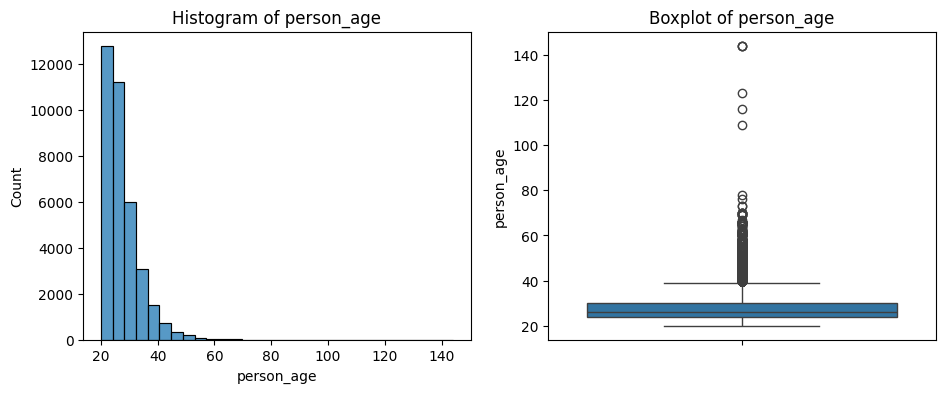

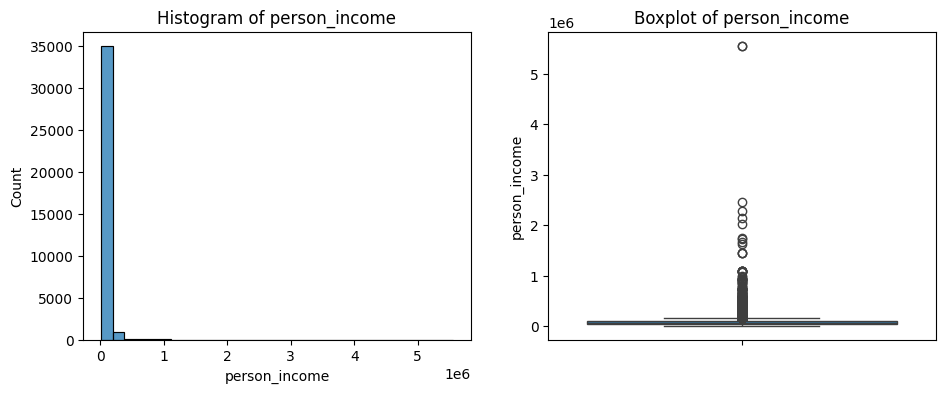

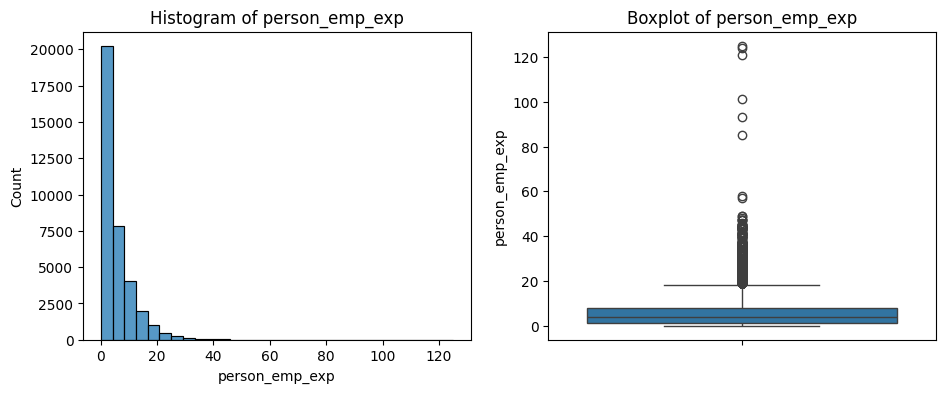

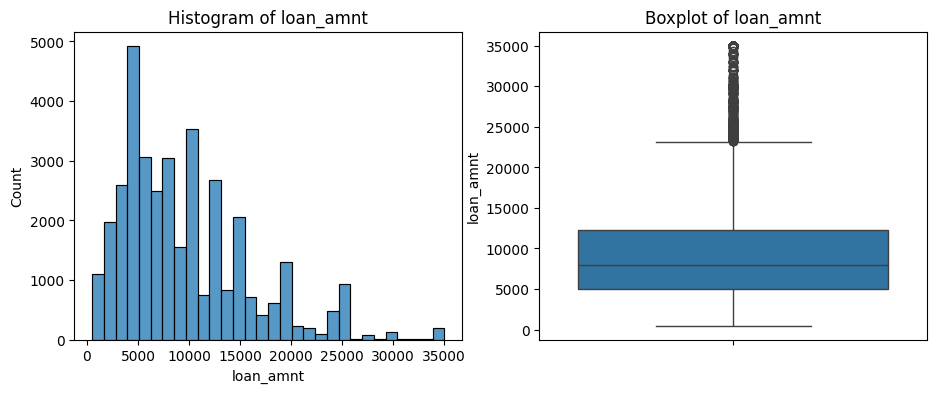

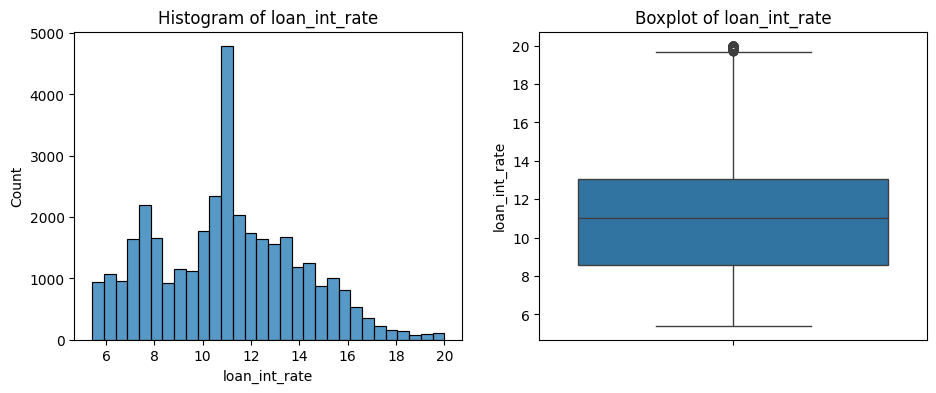

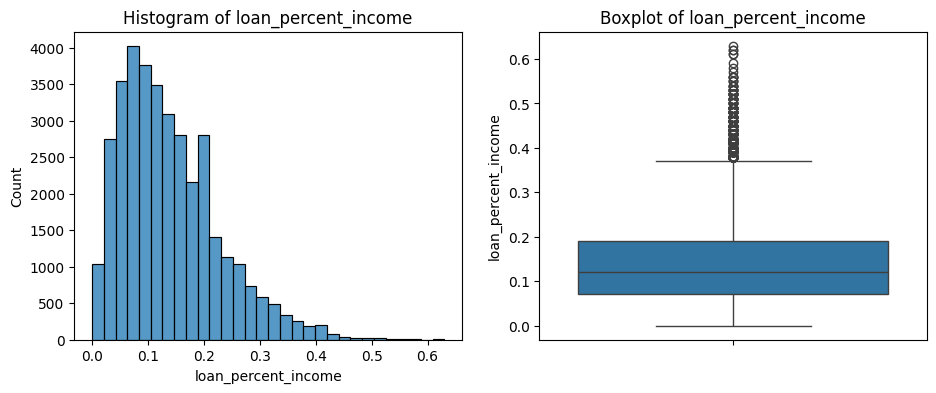

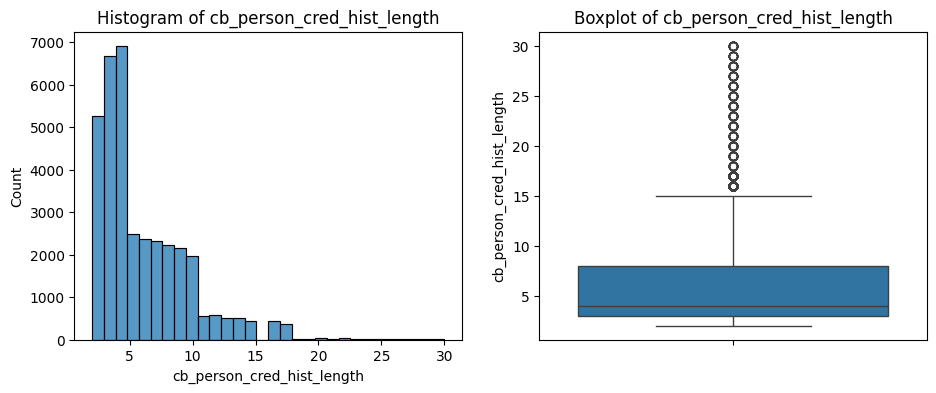

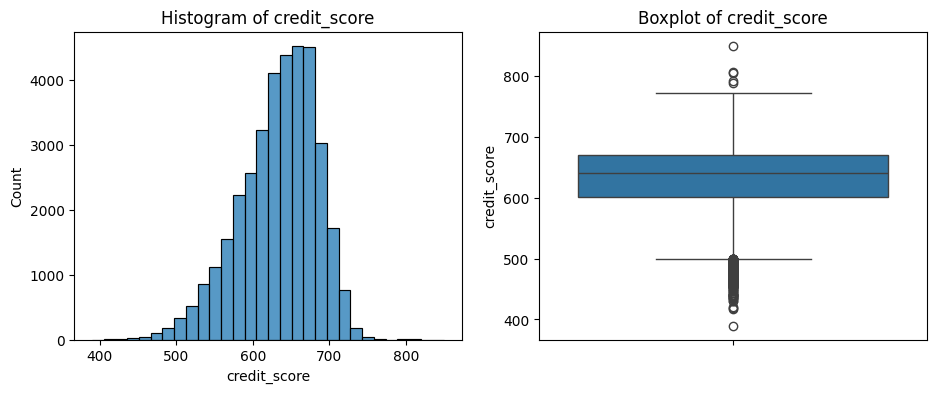

In [888]:
def dist_plot(df, numerical_cols):
  for i in numerical_cols:
    plt.figure(figsize=(11,4))

    plt.subplot(1,2,1)
    sns.histplot(df[i], bins=30)
    plt.title(f"Histogram of {i}")

    plt.subplot(1,2,2)
    sns.boxplot(df[i])
    plt.title(f"Boxplot of {i}")

    plt.show()
dist_plot(x_train[numerical], numerical)

- Semua distribusi data tidak normal dan memiliki outliers

In [ ]:
df[df['person_age'] >= 80]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
81,144,male,Bachelor,300616.0,125,RENT,4800,VENTURE,13.57,0.02,3,789,No,0
183,144,male,Associate,241424.0,121,MORTGAGE,6000,EDUCATION,11.86,0.02,2,807,No,0
575,123,female,High School,97140.0,101,RENT,20400,EDUCATION,10.25,0.21,3,805,Yes,0
747,123,male,Bachelor,94723.0,100,RENT,20000,VENTURE,11.01,0.21,4,714,Yes,0
32297,144,female,Associate,NaN,124,MORTGAGE,5000,PERSONAL,12.73,0.00,25,850,No,0
32416,94,male,High School,29738.0,76,RENT,6500,MEDICAL,11.01,0.22,27,773,No,0
32422,80,male,High School,77894.0,62,RENT,6800,MEDICAL,11.71,0.09,25,673,No,0
32506,84,male,High School,114705.0,61,MORTGAGE,10000,PERSONAL,7.51,0.09,24,784,Yes,0
37930,116,male,Bachelor,5545545.0,93,MORTGAGE,3823,VENTURE,12.15,0.00,24,708,No,0
38113,109,male,High School,5556399.0,85,MORTGAGE,6195,VENTURE,12.58,0.00,22,792,No,0


- Saya check sample data outliersnya pada df karena mau melihat apakah loan status diterima apa tidak
- Terlihat bahwa outliers tersebut menunjukan bahwa mereka sudah bekerja dari usia sekitar 20 hingga masa tua nya tanpa henti
- Walaupun usia orang memang sangat langka bisa mencapai diatas 100 tahun, namun usia tersebut masih dapat dijumpai dan masih masuk akal
- sehingga saya tidak akan menghapus atau mengubah person_age dan person_emp_ex karena data tersebut masih merepresentasikan kondisi nyata yang mungkin berguna dalam analisis model dalam kelayakan pinjaman

#### Scale All Column

In [889]:
for col in numerical:
  robust_scaler= RobustScaler()
  
  x_train[col]= robust_scaler.fit_transform(x_train[[col]])
  x_test[col]= robust_scaler.transform(x_test[[col]])
    
  pickle.dump(robust_scaler, open(f"{col}_scaler.pkl", "wb"))

- Karena data numerik tidak berdistribusi normal, maka saya memakai robust scaler untuk menormalisasi data karena robust scaler lebih tahan terhadap outliers dibandingkan scaler lain. Sehingga, saya bisa menjaga informasi penting dari data ekstrem tanpa membuat model terlalu terpengaruh oleh nilai nilai yang tidak umum
- Semua scaler disimpan dalam format pickle agar dapat dipakai lagi saat proses pembuatan kode inferencing tanpa harus scaling manual lagi

## Train Model

### Random Forest

In [ ]:
rf_model= RandomForestClassifier(random_state= 42, criterion= 'gini', max_depth= 4, n_estimators= 100)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

- Membuat model random forest dengan parameter estimator 100, max_depth 4, dan kriteria "gini" untuk pemisahan node. Setelah itu model akan latih dengan data train

In [891]:
y_pred_rf= rf_model.predict(x_test)

- Pake model yang sudah di latih tadi untuk memprediksi loan status pada test data 

### XGBoost  

In [892]:
xgb_model= XGBClassifier(random_state= 42, n_estimators= 100, min_child_weight= 50, max_depth= 8)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=50, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

- Membuat model xgBoost dengan parameter estimator 100, max_depth 8, dan min_child_weight 50 untuk mengontrol kompleksitas tree. Setelah itu model akan latih dengan data train

In [893]:
y_pred_xgb= xgb_model.predict(x_test)

- Pake model yang sudah di latih tadi untuk memprediksi loan status pada test data 

## Evaluation

In [894]:
print('Classification Report Random Forest\n')
print(classification_report(y_test, y_pred_rf))

Classification Report Random Forest

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      6990
           1       0.97      0.48      0.64      2010

    accuracy                           0.88      9000
   macro avg       0.92      0.74      0.79      9000
weighted avg       0.89      0.88      0.87      9000



In [895]:
print('Classification Report XGBoost\n')
print(classification_report(y_test, y_pred_xgb))

Classification Report XGBoost

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.88      0.79      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000



- Berdasarkan nilai accuracy, XGBoost lebih unggul dalam akurasi yang menunjukkan bahwa secara keseluruhan XGBoost memprediksi lebih baik
- Pada kelas 0, XGBoost lebih baik dalam memprediksi kelas 0 walaupun recall pada Random Forest lebih baik. Hal ini terbukti dari nilai f1 score yang lebih tinggi yang menunjukan nilai precision dan recall yang lebih seimbang
- Hal ini juga berlaku sama terhadap kelas 1. Walaupun precision Random Forest lebih tinggi, nilai recall pada XGBoost jauh lebih tinggi. Nilai f1 score XGBoost juga lebih jauh lebih tinggi sebesar 0.2 yang menunjukkan nilai precision dan recall yang lebih seimbang
- Secara keseluruhan, nilai marcro average f1 score XGBoost jauh lebih tinggi yang menandakan model XGBoost lebih bagus dalam memprediksi semua kelas dengan baik
- Sehingga, dapat disimpulkan bahwa model XGBoost merupakan model terbaik

In [896]:
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))

- Karena model XGBoost merupakan model yang terbaik, maka akan disimpan dalam bentuk pickle untuk pembuatan streamlit nanti- Karena model sudah cukup baik, maka tidak diperlukan sampling data